In [4]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

@njit
def f_numba(N, rho, K):
    return rho * N * (1 - N / K)

@njit
def g_numba(N, M, k):
    return -k * M * N

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = - (Dl + Dr)

    # Neumann BCs
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0] = 2 * Dr

    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1] = 2 * Dl

    return (1.0 / dx**2) * lower, (1.0 / dx**2) * center, (1.0 / dx**2) * upper

class Dissertation_Plain_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200):

        self.D = D; self.rho = rho; self.K = K
        self.k = k; self.n0 = n0; self.m0 = m0
        self.steepness = steepness
        self.Mmax = Mmax; self.perc = perc
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt; self.Nt = int(T / dt)
        self.scheme = scheme.upper()
        self.init_type = init_type
        self.times = np.linspace(0, T, self.Nt)
        self.N_arr = np.zeros((self.Nt, self.N))
        self.M_arr = np.zeros((self.Nt, self.N))
        self.wave_speed = None

        # Wave speed tracking parameters
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], [-1, 0, 1], format="csr")

    def solve(self):
        N0, M0 = self.initial_condition()
        N_prev, M_prev = N0.copy(), M0.copy()
        f_prev = f_numba(N_prev, self.rho, self.K)
        g_prev = g_numba(N_prev, M_prev, self.k)
        L_prev = self.update_laplacian(M_prev)

        N_curr = spsolve(eye(self.N) - self.dt * L_prev, N_prev + self.dt * f_prev)
        M_curr = M_prev + self.dt * g_prev

        self.N_arr[0], self.M_arr[0] = N_prev, M_prev
        self.N_arr[1], self.M_arr[1] = N_curr, M_curr

        for i in range(2, self.Nt):
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)
            g_curr = g_numba(N_curr, M_curr, self.k)

            rhs = (eye(self.N) + 0.5 * self.dt * L_prev) @ N_curr + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (eye(self.N) - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            M_next = M_curr + self.dt * g_curr
            self.N_arr[i] = N_next
            self.M_arr[i] = M_next

            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev, g_prev = f_curr, g_curr
            L_prev = L_curr

    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x, y):
            if method == 'cubic': return CubicSpline(x, y)
            if method == 'pchip': return PchipInterpolator(x, y)
            if method == 'akima': return Akima1DInterpolator(x, y)
            if method == 'linear': return interp1d(x, y, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            sort_idx = np.argsort(x_local)
            x_local, u_local = x_local[sort_idx], u_local[sort_idx]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda x_val: spline(x_val) - threshold, bracket=[x_left, x_right])
                if sol.converged:
                    x_star = sol.root
                    x_fronts.append(x_star)
                    t_fronts.append(t_target)
            except:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9), spline_type='cubic',
                            plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None

        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)

        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t")
            plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()

        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2
    
    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                               arrow_len=None, arrow_lw=2.5,
                               arrow_start_frac=0.5,        # start location as fraction of L
                               head_length=6, head_width=3, # arrowhead size
                               bottom_y=0.2):               # y for blue arrow

        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
    
        # Ensure wave speed is available
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )
    
        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L  # default 15% of domain
    
        # Compute start/end, clamped to [0, L]
        arrow_x_start = np.clip(arrow_start_frac * self.L, 0.0, self.L)
        arrow_x_end   = np.clip(arrow_x_start + arrow_len, 0.0, self.L)
        # If clamping collapses the arrow, back off start a bit
        if arrow_x_end <= arrow_x_start:
            arrow_x_start = np.clip(self.L - arrow_len, 0.0, self.L)
            arrow_x_end   = self.L
    
        plt.figure(figsize=(8, 6))
    
        # Plot profiles (dashed for t=0)
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")
    
        # Arrow styles (slightly larger heads)
        arrow_style_red  = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='red',  lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)
    
        # Draw arrows, aligned horizontally
        plt.annotate('', xy=(arrow_x_end, 0.9),     xytext=(arrow_x_start, 0.9),     arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end, bottom_y), xytext=(arrow_x_start, bottom_y), arrowprops=arrow_style_blue)
    
        # Left-side text (speed string: take first 4 chars without rounding)
        x_text = x[0] + 0.02 * self.L
        c_str = str(self.wave_speed)[:4] if self.wave_speed is not None else "—"
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')
    
        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()
    
    def compute_total_n_plus_m(self):
        dx = self.dx
        total_sum = np.sum(self.N_arr + self.M_arr, axis=1) * dx
        return self.times, total_sum

    def plot_total_n_plus_m(self):
        t, total_sum = self.compute_total_n_plus_m()
        plt.figure(figsize=(8, 4))
        plt.plot(t, total_sum, 'b-', lw=2)
        plt.xlabel("Time t")
        plt.ylabel(r"$\int (n+m) \, dx$")
        plt.title("Total n + m over time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def compute_total_n_plus_m(self, method: str = "trapz", normalise: bool = False):
        """
    Total (mass) of n+m over space for each time step.
    method: 'trapz' (recommended) or 'rect' (sum*dx)
    normalise: divide by t=0 value
    """
    if method == "trapz":
        total = np.trapz(self.N_arr + self.M_arr, x=self.x, axis=1)
    elif method == "rect":
        total = np.sum(self.N_arr + self.M_arr, axis=1) * self.dx
    else:
        raise ValueError("method must be 'trapz' or 'rect'")
    if normalise and abs(total[0]) > 0:
        total = total / total[0]
    return self.times, total

    def compute_total_each(self, method: str = "trapz", normalise: bool = False):
        """
        Total (mass) of n and m over space for each time step (separately).
        Returns (times, total_n, total_m)
        """
        if method == "trapz":
            total_n = np.trapz(self.N_arr, x=self.x, axis=1)
            total_m = np.trapz(self.M_arr, x=self.x, axis=1)
        elif method == "rect":
            total_n = np.sum(self.N_arr, axis=1) * self.dx
            total_m = np.sum(self.M_arr, axis=1) * self.dx
        else:
            raise ValueError("method must be 'trapz' or 'rect'")
    
        if normalise:
            if abs(total_n[0]) > 0: total_n = total_n / total_n[0]
            if abs(total_m[0]) > 0: total_m = total_m / total_m[0]
    
        return self.times, total_n, total_m
    
    def plot_total_n_plus_m(self, method: str = "trapz", normalise: bool = False):
        """
        Plot total (n+m) mass over time.
        """
        t, total = self.compute_total_n_plus_m(method=method, normalise=normalise)
        plt.figure(figsize=(8, 4))
        plt.plot(t, total, lw=2, label=r"$\int (n+m)\,dx$")
        plt.xlabel("Time t")
        ylabel = r"$\int (n+m)\,dx$" if not normalise else r"$\frac{\int (n+m)\,dx}{\int (n+m)\,dx|_{t=0}}$"
        plt.ylabel(ylabel)
        plt.title("Total n + m over time" + (" (normalised)" if normalise else ""))
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    
    def plot_total_each(self, method: str = "trapz", normalise: bool = False):
        """
        Plot total mass of n and m over time (two curves).
        """
        t, total_n, total_m = self.compute_total_each(method=method, normalise=normalise)
        plt.figure(figsize=(8, 4))
        plt.plot(t, total_n, lw=2, label=r"$\int n\,dx$")
        plt.plot(t, total_m, lw=2, label=r"$\int m\,dx$")
        plt.xlabel("Time t")
        if normalise:
            plt.ylabel(r"Normalised mass (by $t=0$)")
            title = "Total n and m over time (normalised)"
        else:
            plt.ylabel(r"Mass")
            title = "Total n and m over time"
        plt.title(title)
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    
    def plot_spatial_sum_profile(self, time_indices=None, use_times=None):
        """
        Plot spatial profiles of (n+m)(x,t) at selected times.
        Choose either `time_indices` (list of integer indices into self.times)
        or `use_times` (list of actual times — we'll pick nearest indices).
        """
        if (time_indices is None) and (use_times is None):
            # default: early/mid/late snapshots
            time_indices = [int(self.Nt*frac) for frac in [0.1, 0.5, 0.9]]
    
        if use_times is not None:
            # map requested times to nearest indices
            time_indices = [int(np.argmin(np.abs(self.times - tt))) for tt in use_times]
    
        plt.figure(figsize=(10, 4.8))
        for idx in time_indices:
            idx = int(np.clip(idx, 0, self.Nt - 1))
            nm = self.N_arr[idx] + self.M_arr[idx]
            plt.plot(self.x, nm, lw=1.8, label=fr"$t={self.times[idx]:.2f}$")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$n(x,t)+m(x,t)$")
        plt.title(r"Spatial profile of $n+m$")
        plt.ylim([-0.05, 1.05])
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

SyntaxError: 'return' outside function (16990814.py, line 275)

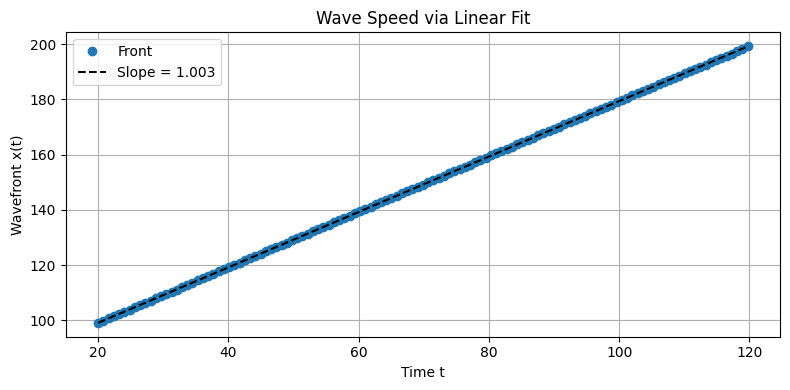

Estimated speed = 1.0035, R² = 1.0000
Estimated speed = 1.0035, R² = 1.0000


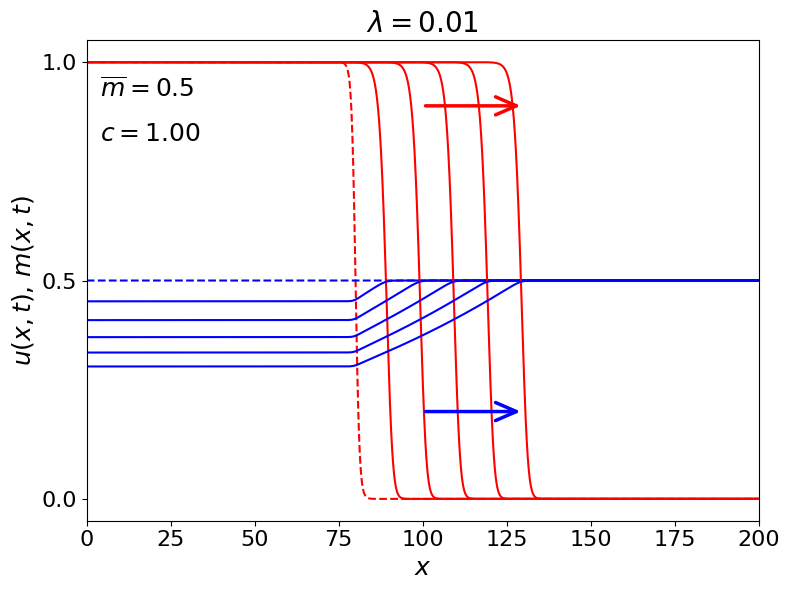

In [2]:
model_05_01 = Dissertation_Plain_1D(
    L=200, N=5001, T=200, dt=0.1, k = 0.01,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=20, t_end=180, num_points=200
)
model_05_01.solve()
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

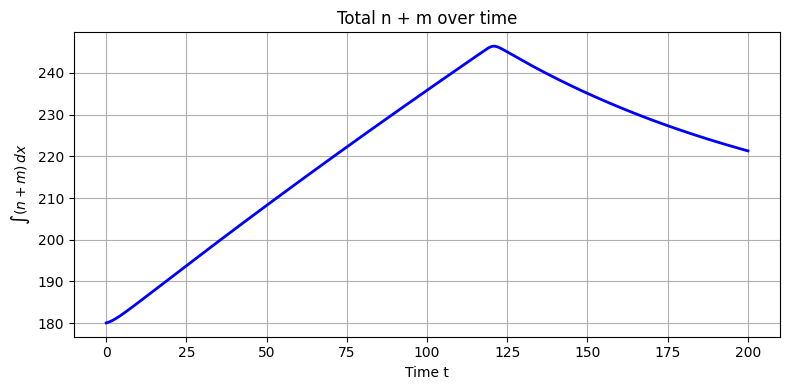

In [3]:
model_05_01.plot_total_n_plus_m()

In [15]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

# ---------- Numba kernels ----------
@njit
def f_numba(N, rho, K):
    # logistic growth for tumour
    return rho * N * (1 - N / K)

@njit
def g_numba(N, M, k):
    # ECM decay due to tumour
    return -k * M * N

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    """
    Variable-coefficient diffusion with edge-averaged M:
    (D * M*(1-M) * u_x)_x  with homogeneous Neumann BCs.
    Returns three diagonals (lower, center, upper) scaled by 1/dx^2.
    """
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = -(Dl + Dr)

    # Neumann at boundaries using ghost-point equivalence
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0] =  2 * Dr

    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1]  =  2 * Dl

    inv_dx2 = 1.0 / (dx * dx)
    return inv_dx2 * lower, inv_dx2 * center, inv_dx2 * upper


class Dissertation_Plain_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200):

        self.D = D; self.rho = rho; self.K = K
        self.k = k; self.n0 = n0; self.m0 = m0
        self.steepness = steepness
        self.Mmax = Mmax; self.perc = perc
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt; self.Nt = int(T / dt)
        self.scheme = scheme.upper()
        self.init_type = init_type

        self.times = np.linspace(0, T, self.Nt)
        self.N_arr = np.zeros((self.Nt, self.N))
        self.M_arr = np.zeros((self.Nt, self.N))
        self.wave_speed = None

        # wave-speed tracking window
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    # ---------------- Core solver ----------------
    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], [-1, 0, 1], format="csr")

    def solve(self):
        # start-up (BE for N, explicit Euler for M)
        N0, M0 = self.initial_condition()
        N_prev, M_prev = N0.copy(), M0.copy()
        f_prev = f_numba(N_prev, self.rho, self.K)
        g_prev = g_numba(N_prev, M_prev, self.k)
        L_prev = self.update_laplacian(M_prev)

        N_curr = spsolve(eye(self.N) - self.dt * L_prev, N_prev + self.dt * f_prev)
        M_curr = M_prev + self.dt * g_prev

        self.N_arr[0], self.M_arr[0] = N_prev, M_prev
        self.N_arr[1], self.M_arr[1] = N_curr, M_curr

        # AB2–AM2 loop
        for i in range(2, self.Nt):
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)
            g_curr = g_numba(N_curr, M_curr, self.k)

            rhs = (eye(self.N) + 0.5 * self.dt * L_prev) @ N_curr \
                  + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (eye(self.N) - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)

            # Neumann fix (copy neighbor)
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            # explicit M update
            M_next = M_curr + self.dt * g_curr

            # store
            self.N_arr[i] = N_next
            self.M_arr[i] = M_next

            # shift state
            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev = f_curr
            L_prev = L_curr

    # -------------- Wave speed utils --------------
    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x_, y_):
            if method == 'cubic': return CubicSpline(x_, y_)
            if method == 'pchip': return PchipInterpolator(x_, y_)
            if method == 'akima': return Akima1DInterpolator(x_, y_)
            if method == 'linear': return interp1d(x_, y_, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            si = np.argsort(x_local)
            x_local, u_local = x_local[si], u_local[si]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda xv: spline(xv) - threshold, bracket=[x_left, x_right])
                if sol.converged:
                    x_fronts.append(sol.root); t_fronts.append(t_target)
            except Exception:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9), spline_type='cubic',
                            plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None
        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)
        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t"); plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2

    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                                   arrow_len=None, arrow_lw=2.5,
                                   arrow_start_frac=0.5, head_length=6, head_width=3,
                                   bottom_y=0.2):
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )
        if arrow_len is None:
            arrow_len = 0.15 * self.L
        arrow_x_start = np.clip(arrow_start_frac * self.L, 0.0, self.L)
        arrow_x_end   = np.clip(arrow_x_start + arrow_len, 0.0, self.L)
        if arrow_x_end <= arrow_x_start:
            arrow_x_start = np.clip(self.L - arrow_len, 0.0, self.L)
            arrow_x_end   = self.L

        plt.figure(figsize=(8, 6))
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")

        arrow_style_red  = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='red',  lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)

        plt.annotate('', xy=(arrow_x_end, 0.9),      xytext=(arrow_x_start, 0.9),      arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end, bottom_y), xytext=(arrow_x_start, bottom_y), arrowprops=arrow_style_blue)

        x_text = x[0] + 0.02 * self.L
        c_str = str(self.wave_speed)[:4] if self.wave_speed is not None else "—"
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')

        plt.xlabel(r"$x$"); plt.ylabel(r"$u(x,t),\, m(x,t)$")
        plt.ylim([-0.05, 1.05]); plt.yticks([0.0, 0.5, 1.0])
        plt.title(rf"$\lambda = {self.k}$")
        plt.xlim([0, self.L]); plt.grid(False); plt.tight_layout(); plt.show()

    def estimate_m_wave_speed(self, threshold=None, band=None, spline_type='cubic', plot=True):
        if threshold is None:
            threshold = 0.5 * self.m0 * self.Mmax
        if band is None:
            lo = 0.1 * self.m0 * self.Mmax
            hi = 0.9 * self.m0 * self.Mmax
            band = (lo, hi)
    
        return self.estimate_wave_speed(
            threshold=threshold,
            band=band,
            spline_type=spline_type,
            plot=plot,
            target='M'
        )

    # -------- Integrals & plots for n+m over time --------
    def compute_total_n_plus_m(self, method: str = "trapz", normalise: bool = False):
        """
        Total (mass) of n+m over space for each time step.
        method: 'trapz' (uses np.trapezoid) or 'rect' (sum*dx)
        """
        if method == "trapz":
            total = np.trapezoid(self.N_arr + self.M_arr, x=self.x, axis=1)
        elif method == "rect":
            total = np.sum(self.N_arr + self.M_arr, axis=1) * self.dx
        else:
            raise ValueError("method must be 'trapz' or 'rect'")
        if normalise and abs(total[0]) > 0:
            total = total / total[0]
        return self.times, total

    def compute_total_each(self, method: str = "trapz", normalise: bool = False):
        """
        Total (mass) of n and m over space for each time step (separately).
        Returns (times, total_n, total_m)
        """
        if method == "trapz":
            total_n = np.trapezoid(self.N_arr, x=self.x, axis=1)
            total_m = np.trapezoid(self.M_arr, x=self.x, axis=1)
        elif method == "rect":
            total_n = np.sum(self.N_arr, axis=1) * self.dx
            total_m = np.sum(self.M_arr, axis=1) * self.dx
        else:
            raise ValueError("method must be 'trapz' or 'rect'")
        if normalise:
            if abs(total_n[0]) > 0: total_n = total_n / total_n[0]
            if abs(total_m[0]) > 0: total_m = total_m / total_m[0]
        return self.times, total_n, total_m

    def plot_total_n_plus_m(self, method: str = "trapz", normalise: bool = False):
        t, total = self.compute_total_n_plus_m(method=method, normalise=normalise)
        plt.figure(figsize=(8, 4))
        plt.plot(t, total, lw=2, label=r"$\int (n+m)\,dx$")
        plt.xlabel("Time t")
        ylabel = r"$\int (n+m)\,dx$" if not normalise else r"$\frac{\int (n+m)\,dx}{\int (n+m)\,dx|_{t=0}}$"
        plt.ylabel(ylabel)
        plt.title("Total n + m over time" + (" (normalised)" if normalise else ""))
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    def plot_total_each(self, method: str = "trapz", normalise: bool = False):
        t, total_n, total_m = self.compute_total_each(method=method, normalise=normalise)
        plt.figure(figsize=(8, 4))
        plt.plot(t, total_n, lw=2, label=r"$\int n\,dx$")
        plt.plot(t, total_m, lw=2, label=r"$\int m\,dx$")
        plt.xlabel("Time t")
        plt.ylabel("Normalised mass (by $t=0$)" if normalise else "Mass")
        plt.title("Total n and m over time" + (" (normalised)" if normalise else ""))
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # -------- Space and time views for n+m --------
    def plot_spatial_sum_profile(self, time_indices=None, use_times=None, ylim=None):
        if (time_indices is None) and (use_times is None):
            time_indices = [int(self.Nt*frac) for frac in [0.1, 0.5, 0.9]]
        if use_times is not None:
            time_indices = [int(np.argmin(np.abs(self.times - tt))) for tt in use_times]
    
        plt.figure(figsize=(10, 4.8))
        for idx in time_indices:
            idx = int(np.clip(idx, 0, self.Nt - 1))
            nm = self.N_arr[idx] + self.M_arr[idx]
            plt.plot(self.x, nm, lw=1.8, label=fr"$t={self.times[idx]:.2f}$")
    
        plt.xlabel(r"$x$")
        plt.ylabel(r"$n(x,t)+m(x,t)$")
        plt.title(r"Spatial profile of $n+m$")
        if ylim is not None:
            plt.ylim(ylim)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_time_traces_sum(self, x_points=None):
        """
        Time traces of (n+m)(x,t) at selected spatial locations.
        x_points: list of x-values; nearest grid point is used.
        """
        if x_points is None:
            x_points = [0.25*self.L, 0.5*self.L, 0.75*self.L]
        idxs = [int(np.argmin(np.abs(self.x - xp))) for xp in x_points]

        plt.figure(figsize=(10, 4.8))
        for xp, j in zip(x_points, idxs):
            nm_t = self.N_arr[:, j] + self.M_arr[:, j]
            plt.plot(self.times, nm_t, lw=1.8, label=fr"$x={xp:.2f}$")
        plt.xlabel("Time t"); plt.ylabel(r"$n+m$")
        plt.title(r"Time traces of $n+m$ at fixed $x$")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    def plot_spacetime_sum(self, vmin=0.0, vmax=1.0, use_imshow=True):
        """
        Space–time heatmap of (n+m)(x,t).
        Defaults clamp colour range to [0,1] for your scaling.
        """
        nm = self.N_arr + self.M_arr  # shape (Nt, N)
        plt.figure(figsize=(9.5, 5))
        if use_imshow:
            plt.imshow(nm, aspect='auto', origin='lower',
                       extent=[self.x[0], self.x[-1], self.times[0], self.times[-1]],
                       vmin=vmin, vmax=vmax)
        else:
            X, T = np.meshgrid(self.x, self.times)
            plt.pcolormesh(X, T, nm, shading='auto', vmin=vmin, vmax=vmax)
        cbar = plt.colorbar()
        cbar.set_label(r"$n(x,t) + m(x,t)$")
        plt.xlabel(r"$x$"); plt.ylabel(r"$t$")
        plt.title(r"Space–time map of $n+m$")
        plt.tight_layout(); plt.show()

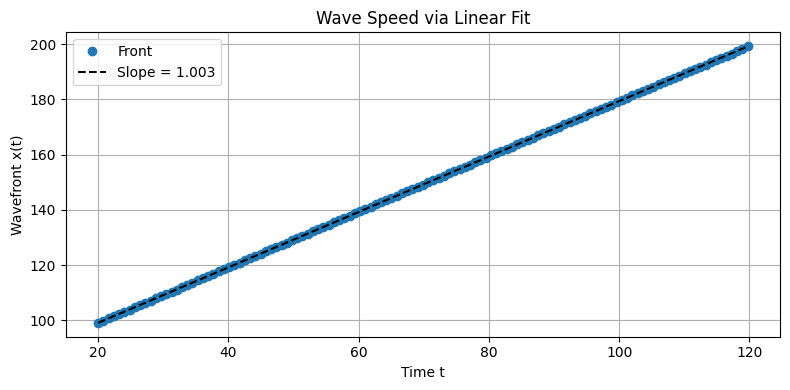

Estimated speed = 1.0035, R² = 1.0000


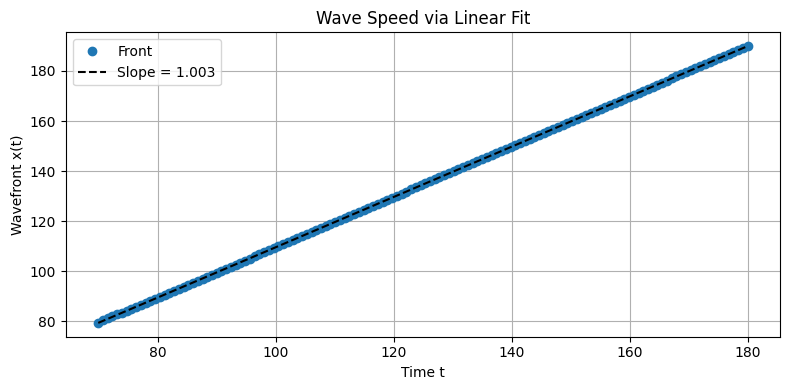

Estimated speed = 1.0033, R² = 1.0000


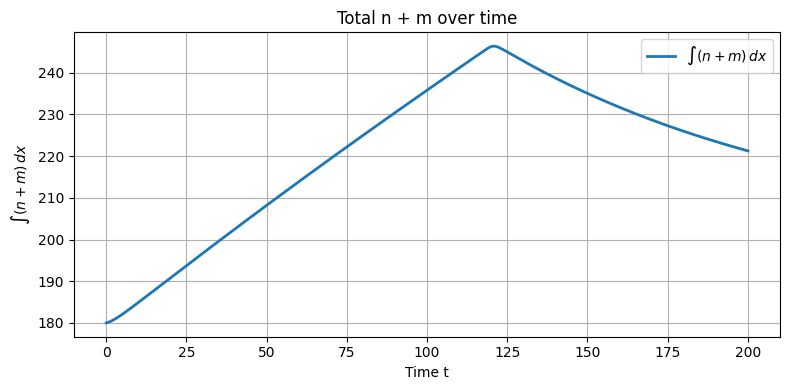

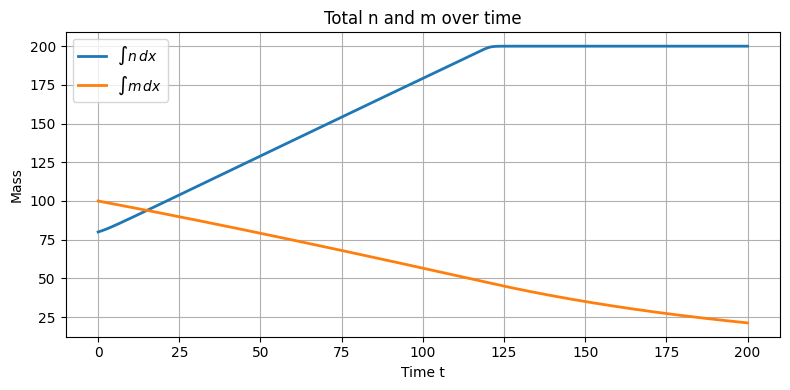

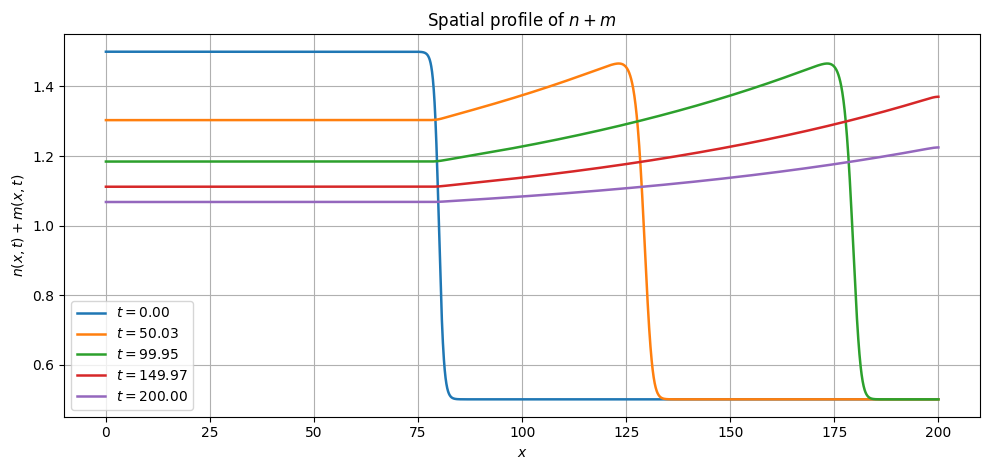

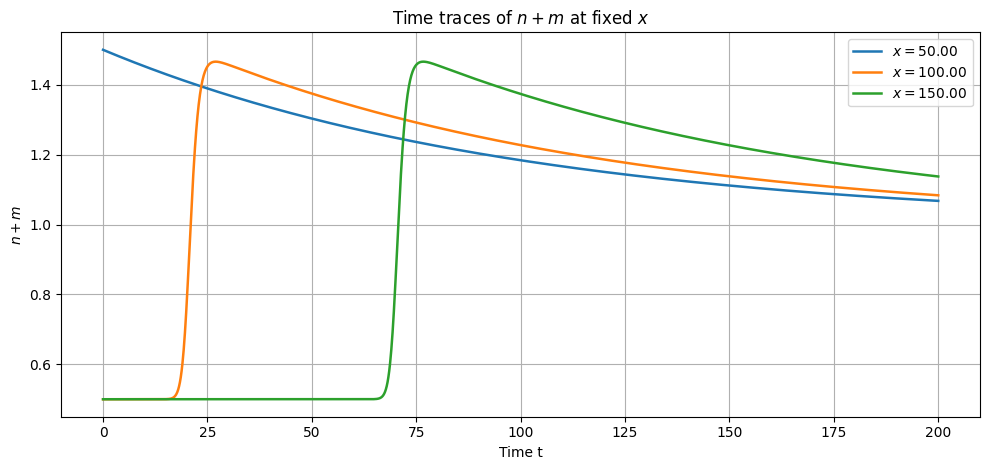

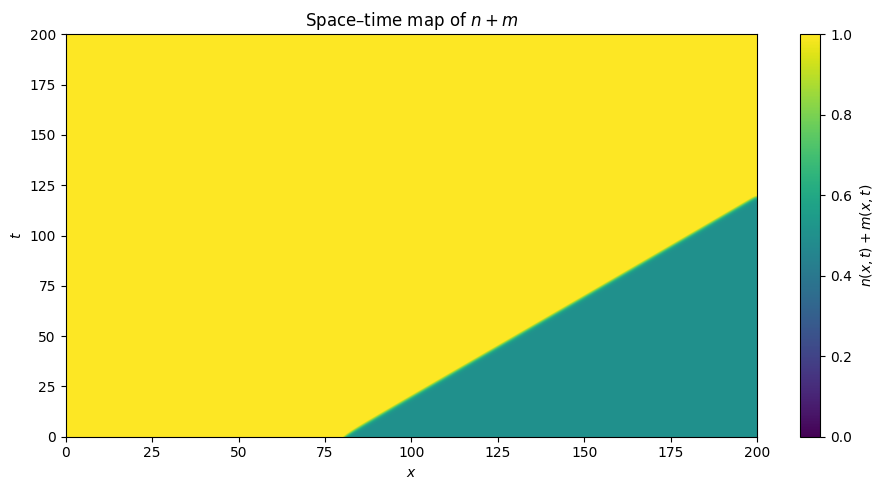

In [23]:
model01 = Dissertation_Plain_1D(L=200, N=5001, T=200, dt=0.1, k=0.01,
                              init_type="tanh", steepness=0.85, perc=0.4,
                              t_start=20, t_end=180, num_points=200)
model01.solve()
# speed of tumour (n) at n=0.5 (what you already have)
model01.estimate_wave_speed(threshold=0.5, target='N', plot=True)

# speed of ECM (m) at m = m0/2
model01.estimate_m_wave_speed(plot=True)

# Mass over time
model01.plot_total_n_plus_m(method="trapz", normalise=False)
model01.plot_total_each(method="trapz", normalise=False)

# Space profiles & time traces
model01.plot_spatial_sum_profile(use_times=[0, 50, 100, 150, 200])
model01.plot_time_traces_sum(x_points=[0.25*model.L, 0.5*model.L, 0.75*model.L])

# Space–time heatmap
model01.plot_spacetime_sum(vmin=0.0, vmax=1.0)

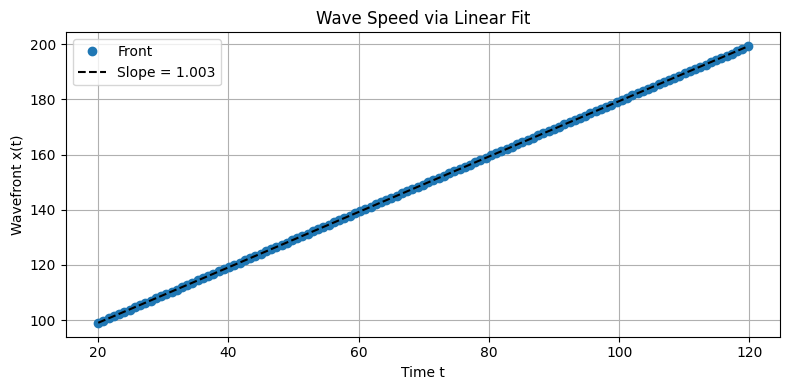

Estimated speed = 1.0035, R² = 1.0000


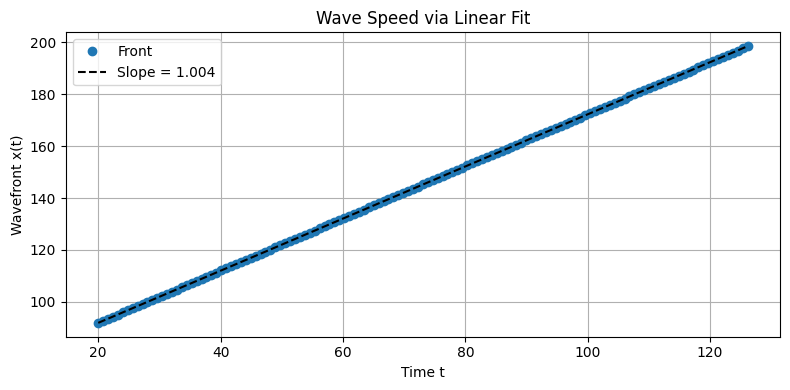

Estimated speed = 1.0036, R² = 1.0000


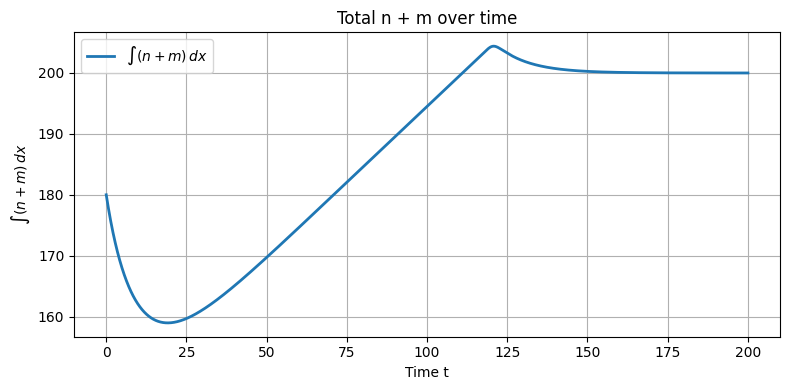

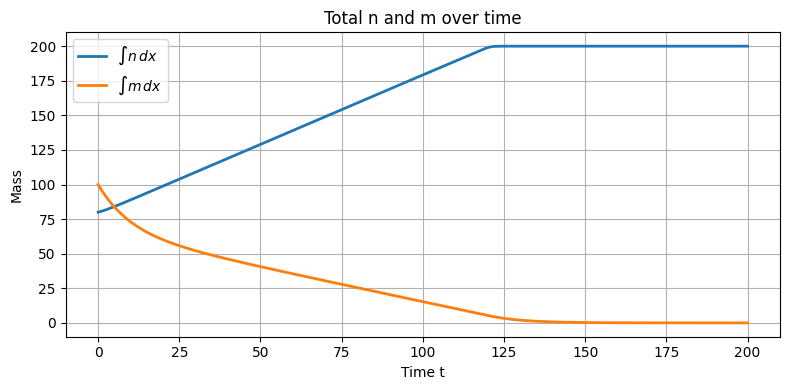

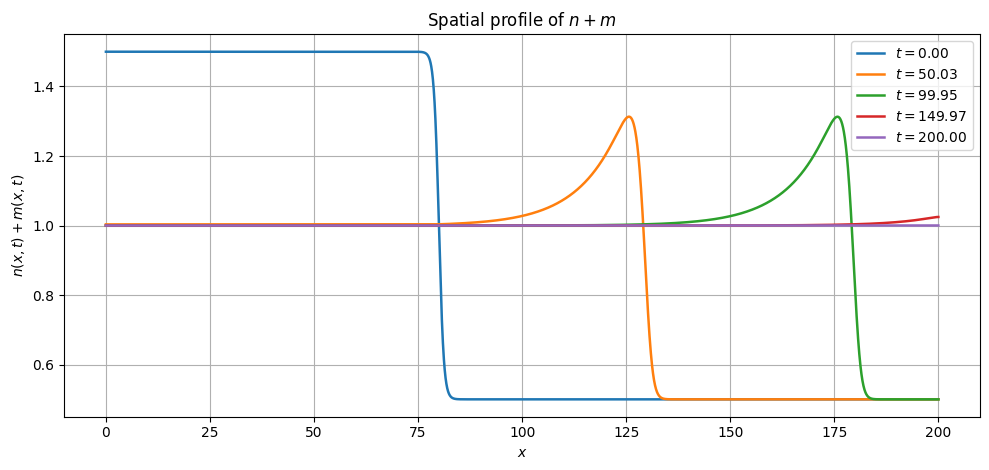

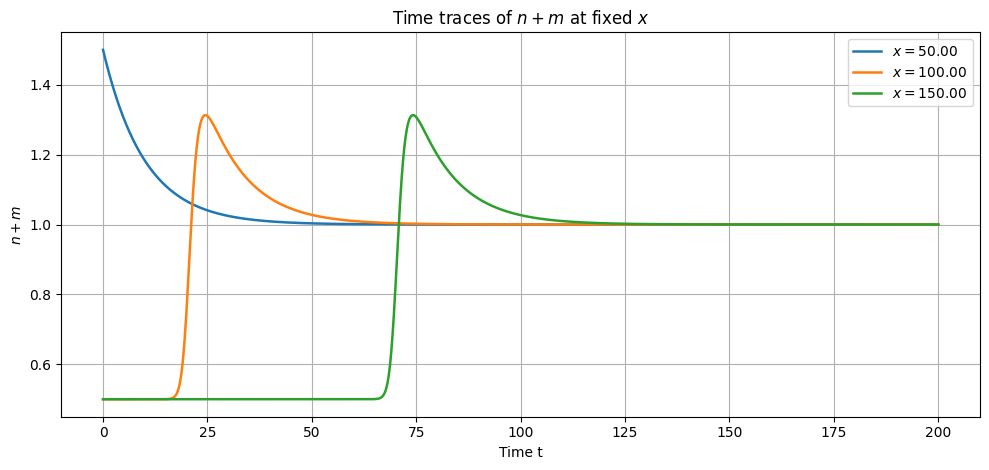

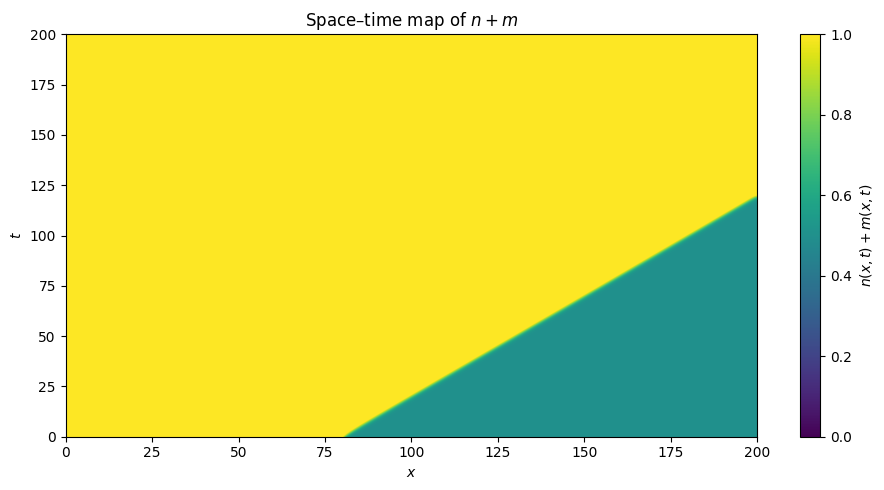

In [17]:
model = Dissertation_Plain_1D(L=200, N=5001, T=200, dt=0.1, k=0.1,
                              init_type="tanh", steepness=0.85, perc=0.4,
                              t_start=20, t_end=180, num_points=200)
model.solve()
# speed of tumour (n) at n=0.5 (what you already have)
model.estimate_wave_speed(threshold=0.5, target='N', plot=True)

# speed of ECM (m) at m = m0/2
model.estimate_m_wave_speed(plot=True)

# Mass over time
model.plot_total_n_plus_m(method="trapz", normalise=False)
model.plot_total_each(method="trapz", normalise=False)

# Space profiles & time traces
model.plot_spatial_sum_profile(use_times=[0, 50, 100, 150, 200])
model.plot_time_traces_sum(x_points=[0.25*model.L, 0.5*model.L, 0.75*model.L])

# Space–time heatmap
model.plot_spacetime_sum(vmin=0.0, vmax=1.0)

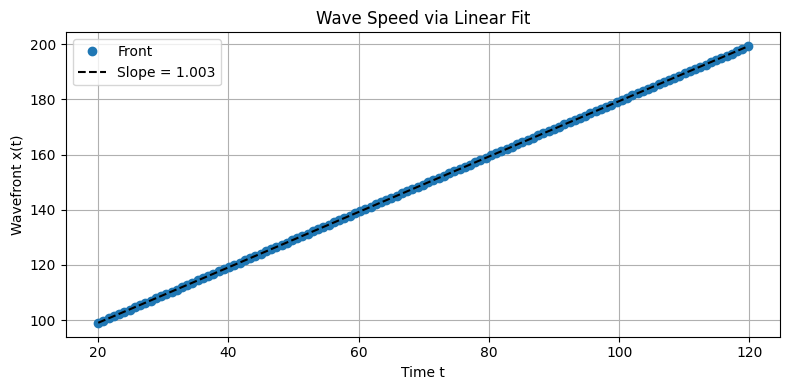

Estimated speed = 1.0035, R² = 1.0000


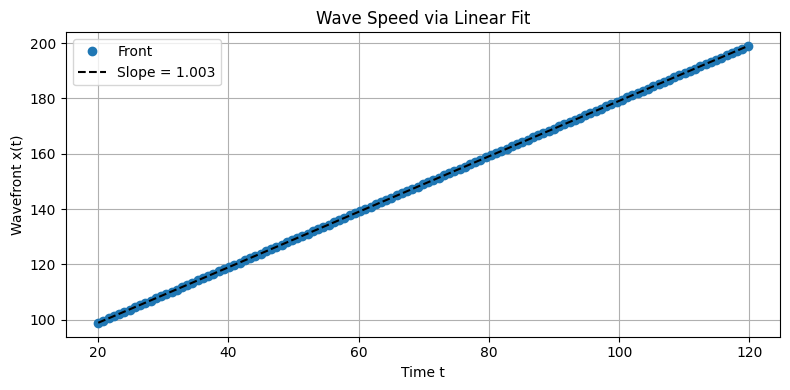

Estimated speed = 1.0033, R² = 1.0000


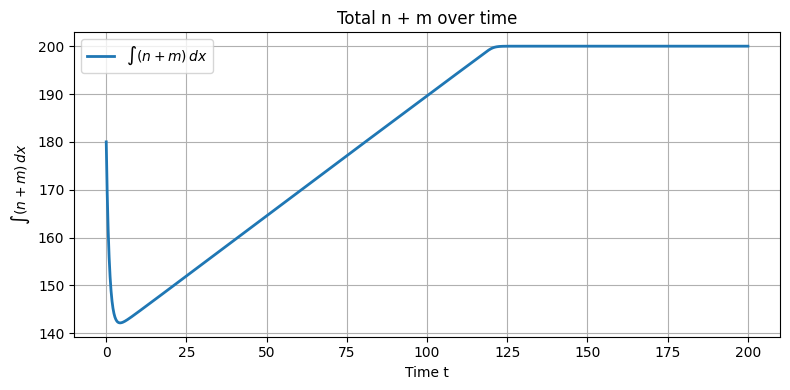

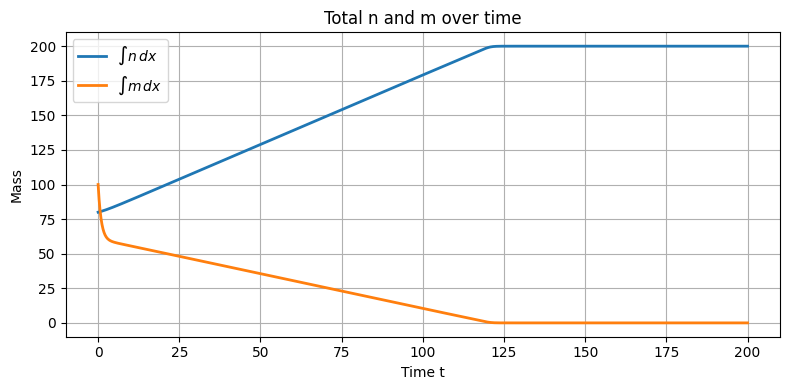

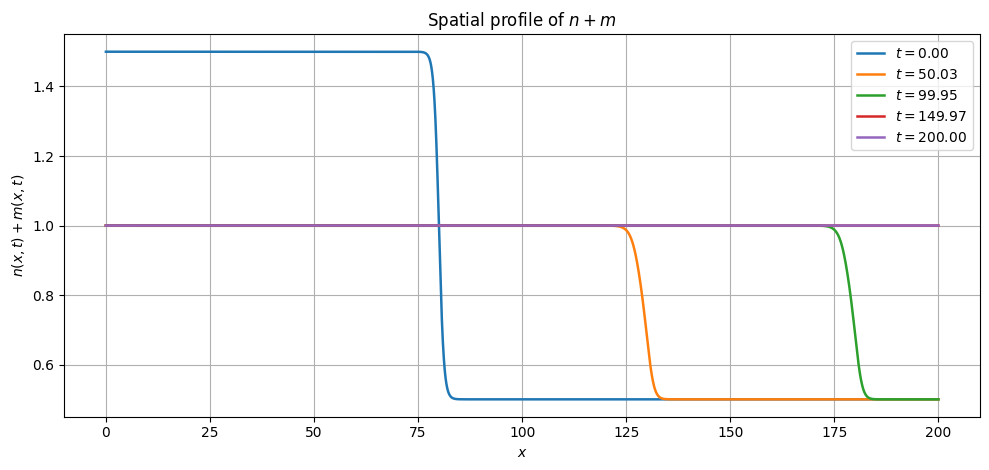

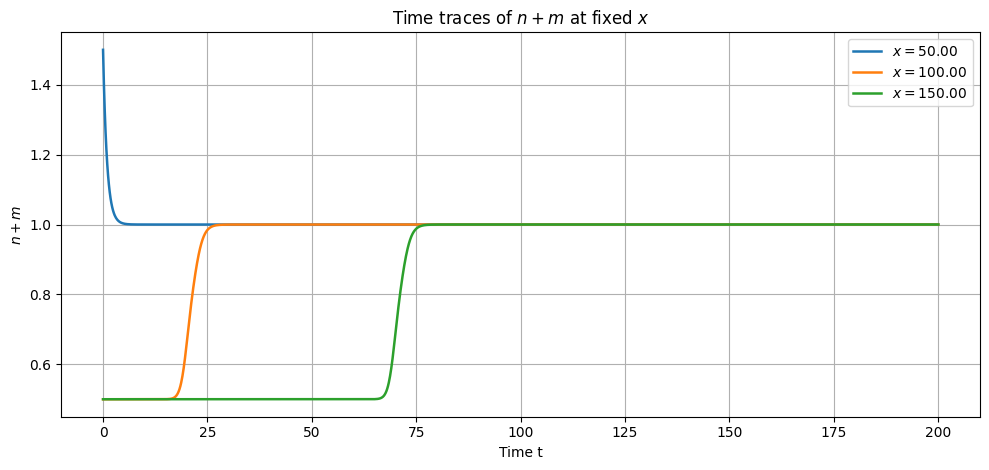

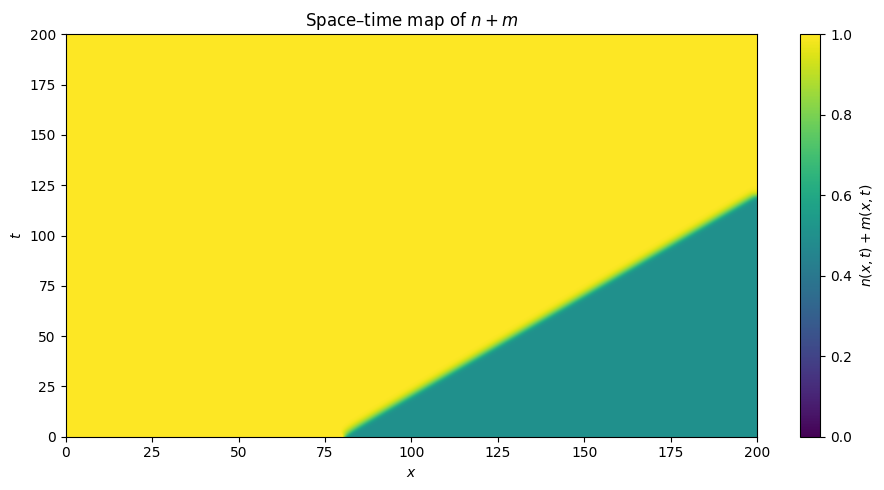

In [18]:
model1 = Dissertation_Plain_1D(L=200, N=5001, T=200, dt=0.1, k=1,
                              init_type="tanh", steepness=0.85, perc=0.4,
                              t_start=20, t_end=180, num_points=200)
model1.solve()
# speed of tumour (n) at n=0.5 (what you already have)
model.estimate_wave_speed(threshold=0.5, target='N', plot=True)

# speed of ECM (m) at m = m0/2
model1.estimate_m_wave_speed(plot=True)

# Mass over time
model1.plot_total_n_plus_m(method="trapz", normalise=False)
model1.plot_total_each(method="trapz", normalise=False)

# Space profiles & time traces
model1.plot_spatial_sum_profile(use_times=[0, 50, 100, 150, 200])
model1.plot_time_traces_sum(x_points=[0.25*model.L, 0.5*model.L, 0.75*model.L])

# Space–time heatmap
model1.plot_spacetime_sum(vmin=0.0, vmax=1.0)

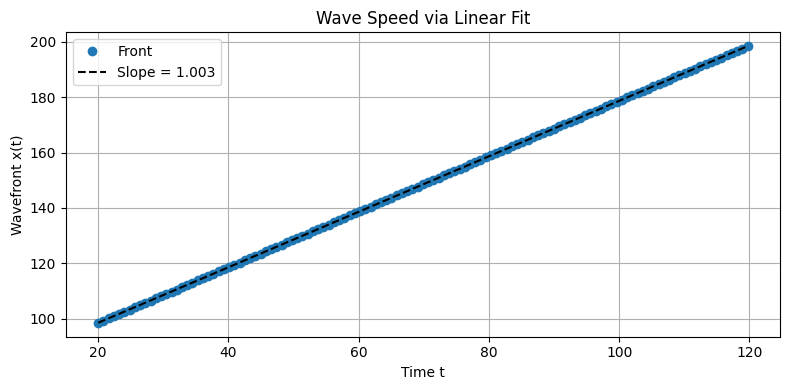

Estimated speed = 1.0031, R² = 1.0000


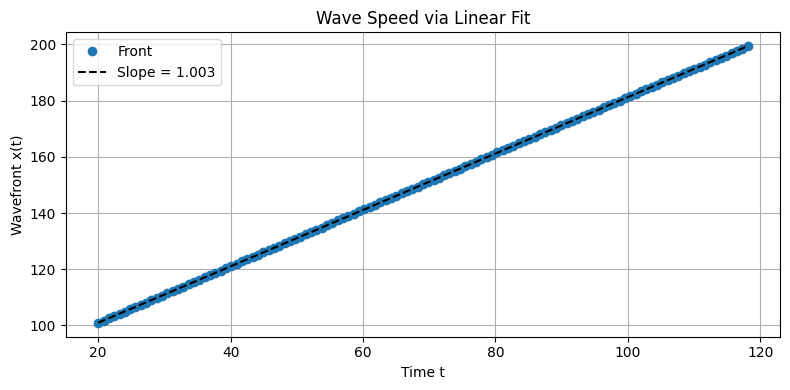

Estimated speed = 1.0030, R² = 1.0000


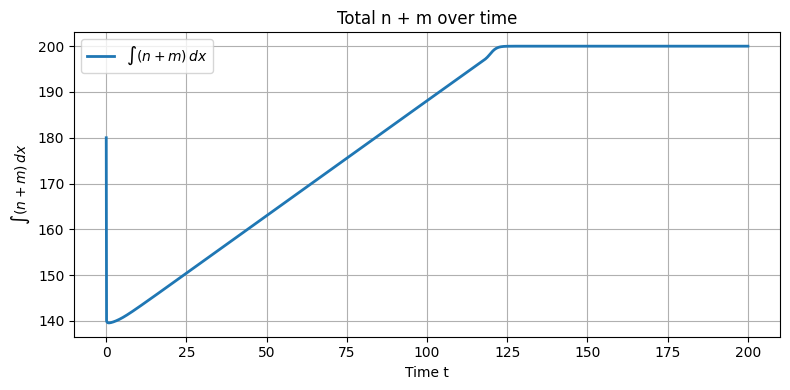

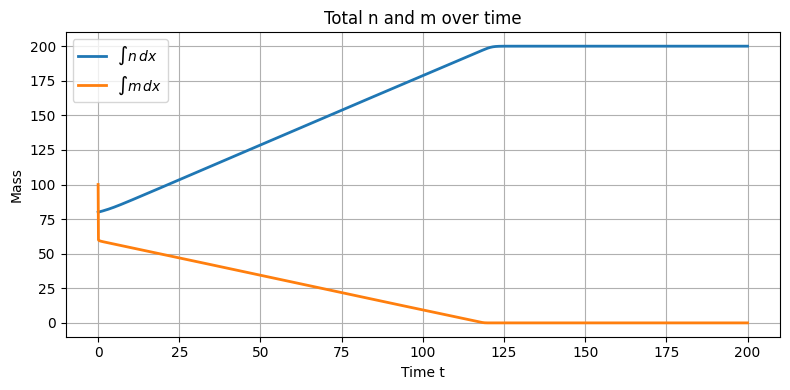

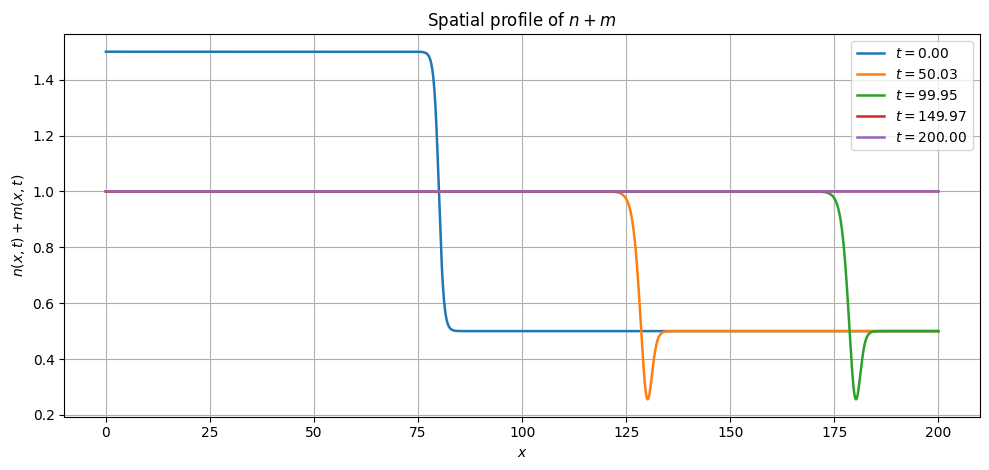

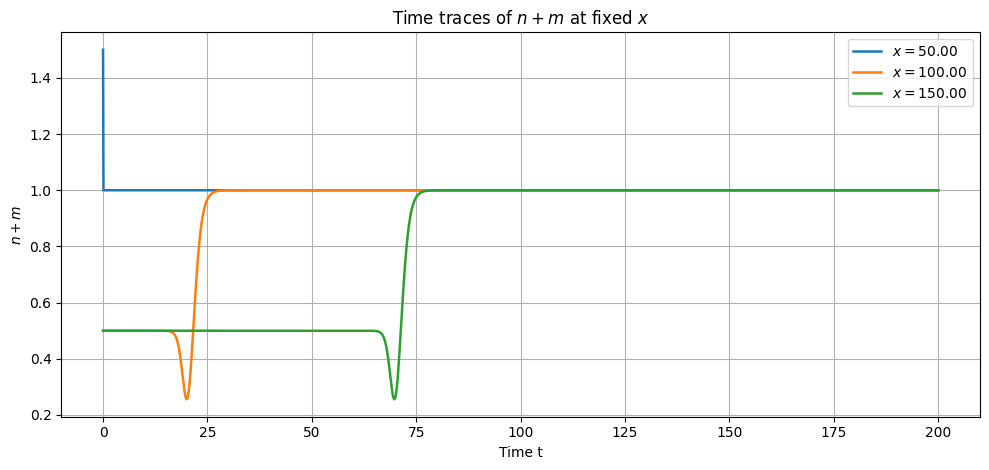

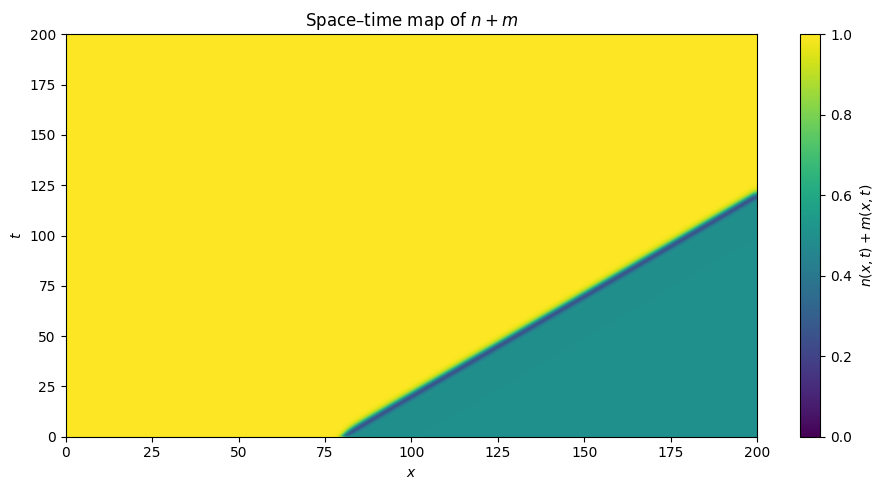

In [24]:
model10 = Dissertation_Plain_1D(L=200, N=5001, T=200, dt=0.1, k=10,
                              init_type="tanh", steepness=0.85, perc=0.4,
                              t_start=20, t_end=180, num_points=200)
model10.solve()
# speed of tumour (n) at n=0.5 (what you already have)
model10.estimate_wave_speed(threshold=0.5, target='N', plot=True)

# speed of ECM (m) at m = m0/2
model10.estimate_m_wave_speed(plot=True)

# Mass over time
model10.plot_total_n_plus_m(method="trapz", normalise=False)
model10.plot_total_each(method="trapz", normalise=False)

# Space profiles & time traces
model10.plot_spatial_sum_profile(use_times=[0, 50, 100, 150, 200])
model10.plot_time_traces_sum(x_points=[0.25*model.L, 0.5*model.L, 0.75*model.L])

# Space–time heatmap
model10.plot_spacetime_sum(vmin=0.0, vmax=1.0)

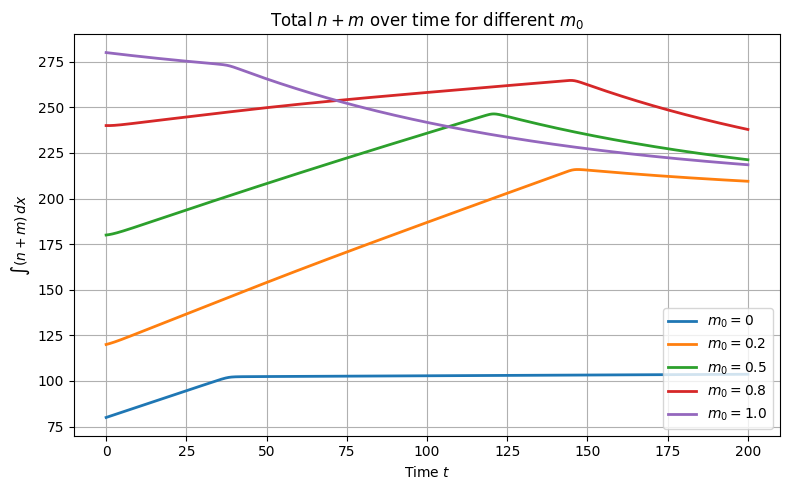

In [25]:
# List of m0 values to compare
m0_values = [0, 0.2, 0.5, 0.8, 1.0]

plt.figure(figsize=(8, 5))

for m0_val in m0_values:
    # Create and solve model for each m0
    model = Dissertation_Plain_1D(
        L=200, N=5001, T=200, dt=0.1, k=0.01,
        m0=m0_val,
        init_type="tanh", steepness=0.85, perc=0.4,
        t_start=20, t_end=180, num_points=200
    )
    model.solve()
    
    # Compute total n+m over time
    times, total_nm = model.compute_total_n_plus_m(method="trapz", normalise=False)
    
    # Plot
    plt.plot(times, total_nm, lw=2, label=fr"$m_0 = {m0_val}$")

plt.xlabel("Time $t$")
plt.ylabel(r"$\int (n+m)\,dx$")
plt.title("Total $n+m$ over time for different $m_0$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()